## Notebook-Dokumentation
- Aggregiert Fahrten nach Stunde/Wochentag/Monat und vergleicht Member vs Casual sowie Bike-Typen.
- Untersucht Trip-Dauer-Verteilung (Boxplots/Hist) und zeitliche Peaks.

Lädt alle Fahrten (2023–2025) mit Schema und Jahresfilter in einen Lazy-Scan; Basis für alle weiteren Aggregationen.

In [1]:
# Load data and set up lazy scan
from pathlib import Path
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

DATA_DIR = Path("../../raw_data/citi_bike")
FILES = (sorted(DATA_DIR.glob("2023-citibike-tripdata/*.csv")) 
    + sorted(DATA_DIR.glob("2024-citibike-tripdata/*.csv")) 
    + sorted(DATA_DIR.glob("2025-citibike-tripdata/*.csv")))


SCHEMA = {
    "ride_id": pl.Utf8,
    "rideable_type": pl.Utf8,
    "started_at": pl.Datetime,
    "ended_at": pl.Datetime,
    "start_station_name": pl.Utf8,
    "start_station_id": pl.Int32,
    "end_station_name": pl.Utf8,
    "end_station_id": pl.Int32,
    "start_lat": pl.Float64,
    "start_lng": pl.Float64,
    "end_lat": pl.Float64,
    "end_lng": pl.Float64,
    "member_casual": pl.Utf8,
}

scan = (
    pl.scan_csv([str(p) for p in FILES], schema=SCHEMA, try_parse_dates=True, ignore_errors=True)
    .filter(
        (pl.col("started_at").dt.year() >= 2023) & (pl.col("started_at").dt.year() <= 2025) &
        (pl.col("ended_at").dt.year() >= 2023) & (pl.col("ended_at").dt.year() <= 2025)
    )
)


Aggregiert Fahrten nach Stunde des Tages (Tagesprofil).

Text(0, 0.5, 'rides')

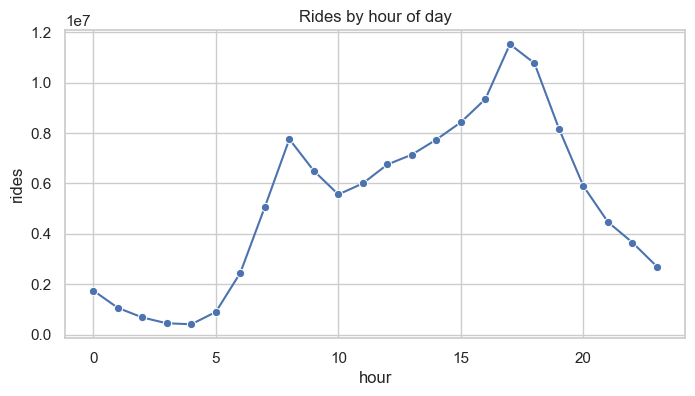

In [2]:
# Aggregate rides by hour
hourly = (
    scan.with_columns(pl.col("started_at").dt.hour().alias("hour"))
    .group_by("hour")
    .agg(pl.len().alias("rides"))
    .sort("hour")
    .collect()
    .to_pandas()
)

plt.figure(figsize=(8, 4))
sns.lineplot(data=hourly, x="hour", y="rides", marker="o")
plt.title("Rides by hour of day")
plt.xlabel("hour")
plt.ylabel("rides")


Aggregiert Fahrten nach Stunde getrennt nach Jahr mit Jahr-Overlay.

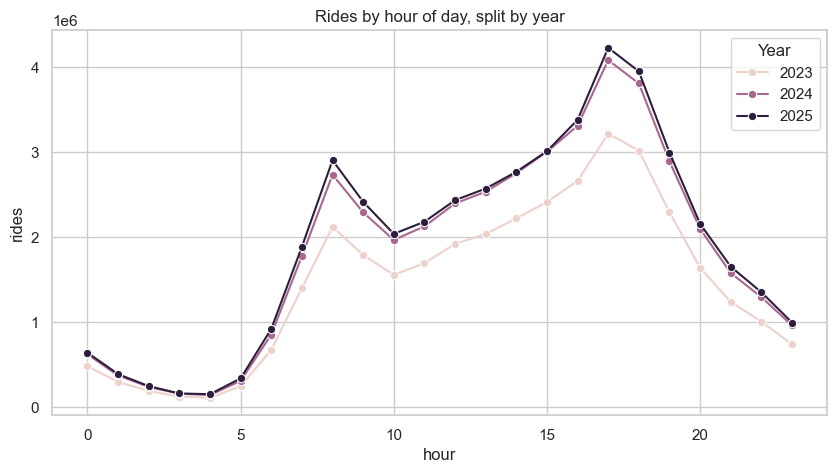

In [3]:
# Aggregate rides by hour and year
hourly_year = (
    scan.with_columns([
        pl.col("started_at").dt.hour().alias("hour"),
        pl.col("started_at").dt.year().alias("year"),
    ])
    .group_by(["year", "hour"])
    .agg(pl.len().alias("rides"))
    .sort(["year", "hour"])
    .collect()
    .to_pandas()
)

plt.figure(figsize=(10, 5))
sns.lineplot(data=hourly_year, x="hour", y="rides", hue="year", marker="o")
plt.title("Rides by hour of day, split by year")
plt.xlabel("hour")
plt.ylabel("rides")
plt.legend(title="Year")

Aggregiert Fahrten nach Wochentag (Wochentagsprofil).

Text(0, 0.5, 'rides')

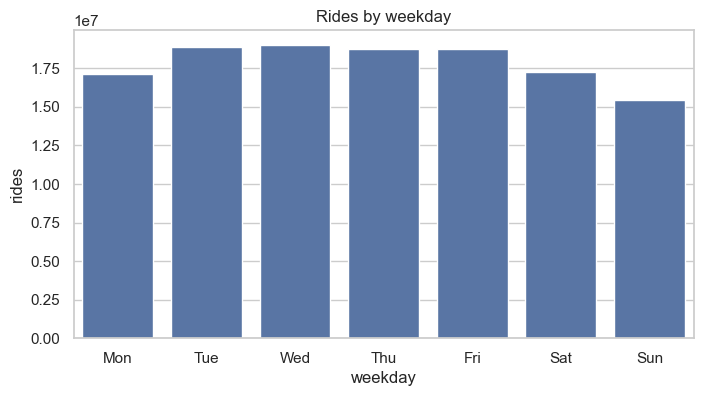

In [4]:
weekday = (
    scan.with_columns(pl.col("started_at").dt.weekday().alias("weekday"))
    .group_by("weekday")
    .agg(pl.len().alias("rides"))
    .sort("weekday")
    .collect()
    .to_pandas()
)
weekday_names = {1: "Mon", 2: "Tue", 3: "Wed", 4: "Thu", 5: "Fri", 6: "Sat", 7: "Sun"}
weekday["weekday_name"] = weekday["weekday"].map(weekday_names)

plt.figure(figsize=(8, 4))
sns.barplot(data=weekday, x="weekday_name", y="rides")
plt.title("Rides by weekday")
plt.xlabel("weekday")
plt.ylabel("rides")


Aggregiert Fahrten nach Wochentag und Jahr, wandelt Wochentag in Label um, mit Jahr-Legende.

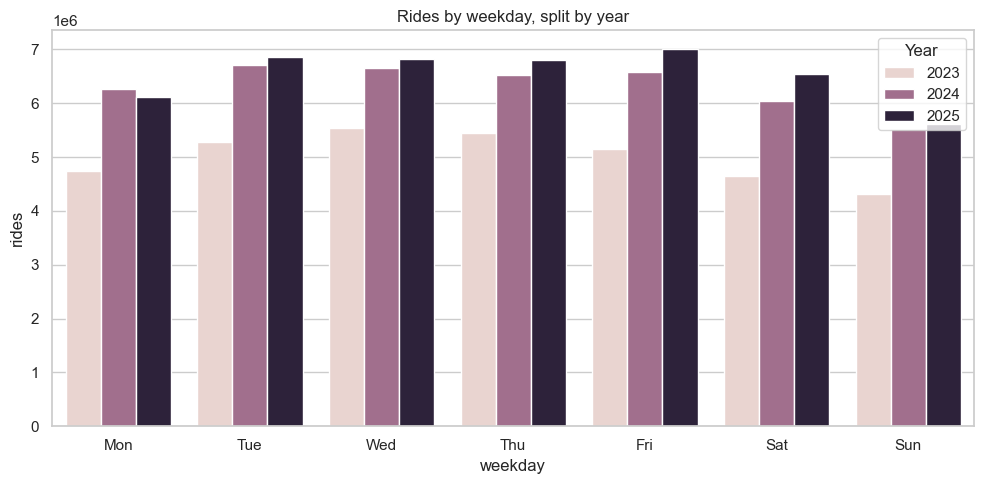

In [6]:
weekday_order = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
weekday_map = pl.DataFrame({
    "weekday": list(weekday_names.keys()),
    "weekday_name": list(weekday_names.values()),
})
weekday_order_df = pl.DataFrame({
    "weekday_name": weekday_order,
    "weekday_sort": list(range(len(weekday_order))),
})

weekday_year = (
    scan.with_columns([
        pl.col("started_at").dt.weekday().alias("weekday"),
        pl.col("started_at").dt.year().alias("year"),
    ])
    .group_by(["year", "weekday"])
    .agg(pl.len().alias("rides"))
    .collect()
)

weekday_year_sorted = (
    weekday_year
    .join(weekday_map, on="weekday", how="left")
    .join(weekday_order_df, on="weekday_name", how="left")
    .sort(["weekday_sort", "year"])
    .drop("weekday_sort")
)

plt.figure(figsize=(10, 5))
sns.barplot(
    x=weekday_year_sorted["weekday_name"].to_list(),
    y=weekday_year_sorted["rides"].to_list(),
    hue=weekday_year_sorted["year"].to_list(),
    order=weekday_order,
    hue_order=sorted(set(weekday_year_sorted["year"].to_list()))
)
plt.title("Rides by weekday, split by year")
plt.xlabel("weekday")
plt.ylabel("rides")
plt.legend(title="Year")
plt.tight_layout()


Violinplot (Startstunde vs. Wochentag, getrennt nach member_casual) und zeigt Verteilung/Quartile.

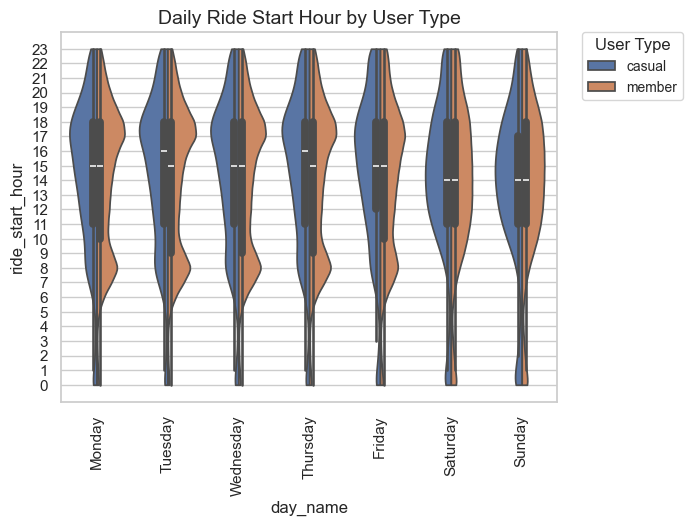

In [9]:
import numpy
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

df = (
    scan.with_columns([
        pl.col("started_at").dt.strftime("%A").alias("day_name"),
        pl.col("started_at").dt.hour().alias("ride_start_hour"),
    ])
    .select(["day_name", "ride_start_hour", "member_casual"])
    .collect()
    .to_pandas()
)

sns.violinplot(
    data=df,
    x="day_name",
    y="ride_start_hour",
    hue="member_casual",
    split=True,
    fill=True,
    order=day_order,
    bw_adjust=3,   # increase bandwidth to smooth the plot
    cut=0            # avoid extending beyond data range
)

plt.xticks(rotation=90)
plt.yticks(numpy.arange(0, 24, 1))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.0, fontsize=10, title='User Type')
plt.title('Daily Ride Start Hour by User Type', fontsize=14)
plt.show()


Aggregiert Fahrten nach Monat (YYYY-MM) über die Zeit.

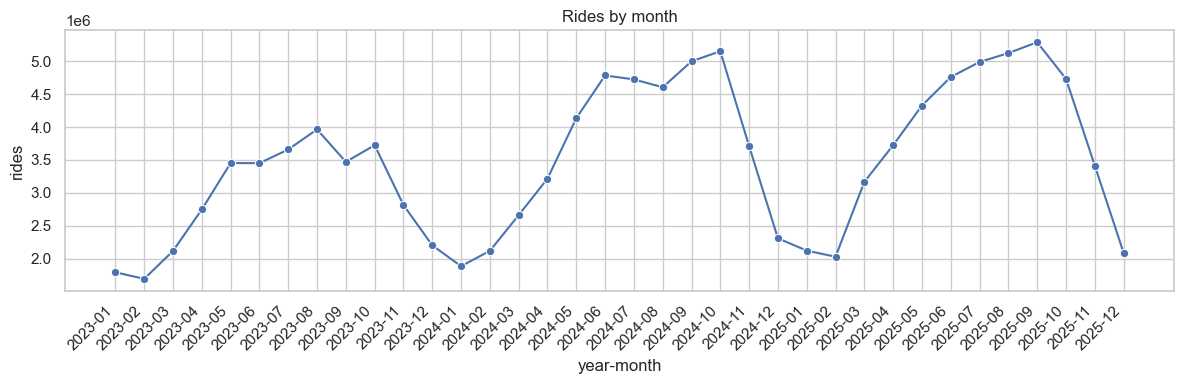

In [ ]:
monthly = (
    scan.with_columns(pl.col("started_at").dt.strftime("%Y-%m").alias("year_month"))
    .group_by("year_month")
    .agg(pl.len().alias("rides"))
    .sort("year_month")
    .collect()
    .to_pandas()
)

plt.figure(figsize=(12, 4))
sns.lineplot(data=monthly, x="year_month", y="rides", marker="o")
plt.xticks(rotation=45, ha="right")
plt.title("Rides by month")
plt.xlabel("year-month")
plt.ylabel("rides")
plt.tight_layout()


Aggregiert Fahrten nach Monat und Jahr, mit Jahr-Legende (saisonale Muster pro Jahr).

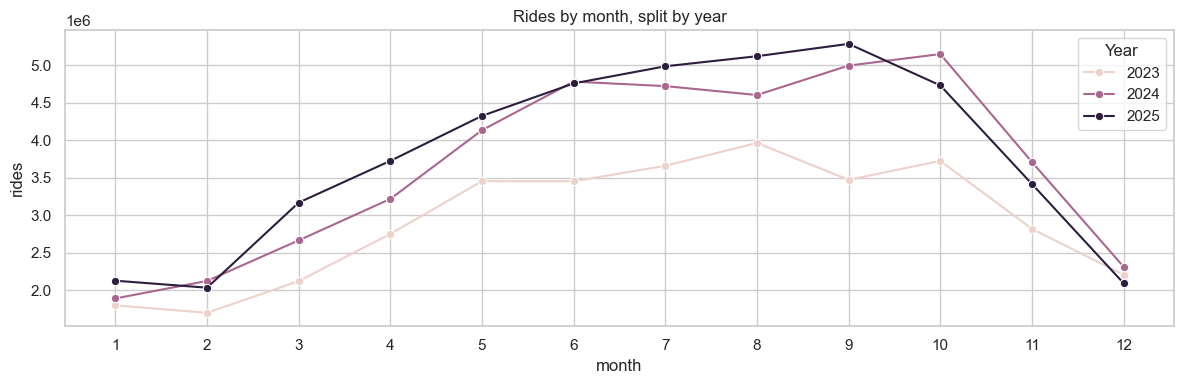

In [ ]:
monthly_year = (
    scan.with_columns([
        pl.col("started_at").dt.year().alias("year"),
        pl.col("started_at").dt.month().alias("month"),
    ])
    .group_by(["year", "month"])
    .agg(pl.len().alias("rides"))
    .sort(["year", "month"])
    .collect()
    .to_pandas()
)

plt.figure(figsize=(12, 4))
sns.lineplot(data=monthly_year, x="month", y="rides", hue="year", marker="o")
plt.title("Rides by month, split by year")
plt.xlabel("month")
plt.ylabel("rides")
plt.legend(title="Year")
plt.xticks(range(1, 13))
plt.tight_layout()

Berechnet Fahrtdauer in Minuten (>1 Min) und fasst Median/Mean nach member_casual und rideable_type zusammen.

In [ ]:
duration = (
    scan.with_columns(
        ((pl.col("ended_at") - pl.col("started_at")).dt.total_seconds() / 60).alias("duration_min")
    ).filter(pl.col("duration_min") > 1)
)

duration_summary = (
    duration.filter((pl.col("duration_min") < 720)).group_by(["member_casual", "rideable_type"])
    .agg(
        pl.median("duration_min").alias("median_min"),
        pl.mean("duration_min").alias("mean_min"),
        pl.len().alias("rides"),
    )
    .sort("median_min", descending=True)
    .collect()
)
duration_summary


member_casual,rideable_type,median_min,mean_min,rides
str,str,f64,f64,u32
"""casual""","""classic_bike""",15.3,21.539125,7499483
"""casual""","""electric_bike""",12.233333,19.053345,15598941
"""member""","""electric_bike""",8.683333,11.595703,63526766
"""member""","""classic_bike""",7.766667,11.047465,38454966


Histogramm der Fahrtdauer (1–60 Minuten) als Verteilungscheck.

Text(0, 0.5, 'rides')

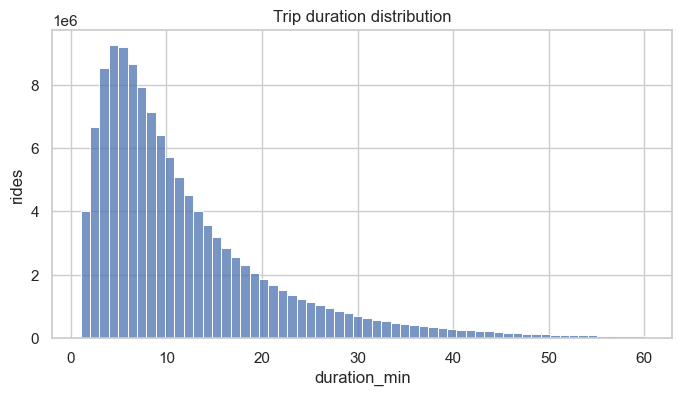

In [ ]:
sample = duration.select(pl.col("duration_min")).filter((pl.col("duration_min") > 1) & (pl.col("duration_min") < 60)).collect().to_pandas()

plt.figure(figsize=(8, 4))
sns.histplot(sample["duration_min"], bins=60)
plt.title("Trip duration distribution")
plt.xlabel("duration_min")
plt.ylabel("rides")


Zählt Anteile sehr langer (>60) und sehr kurzer (<5) Fahrten und druckt absolute Werte plus Prozente.

In [ ]:
total_trips = duration.select(pl.len().alias("count")).collect().item()
long_trips = duration.filter(pl.col("duration_min") > 60).select(pl.len().alias("count")).collect().item()
short_trips = duration.filter(pl.col("duration_min") < 5).select(pl.len().alias("count")).collect().item()

long_pct = long_trips / total_trips * 100
short_pct = short_trips / total_trips * 100

print(f"Trips longer than 60 min: {long_trips} ({long_pct:.2f}%)")
print(f"Trips shorter than 5 min: {short_trips} ({short_pct:.2f}%)")



Trips longer than 60 min: 1475591 (1.18%)
Trips shorter than 5 min: 28935820 (23.12%)


Plottet Verteilungen langer Fahrten (>60, >360 Min) sowie kurzer Fahrten (<5 Min) in mehreren Histogrammen zur Ausreißerprüfung.

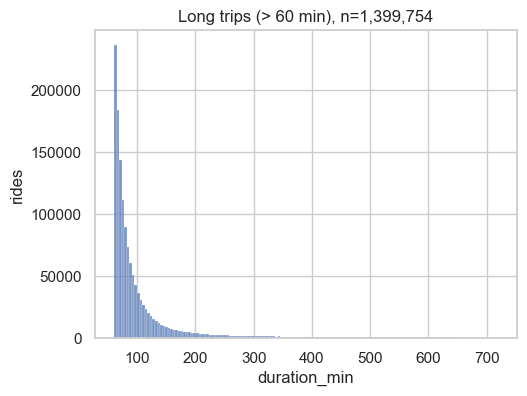

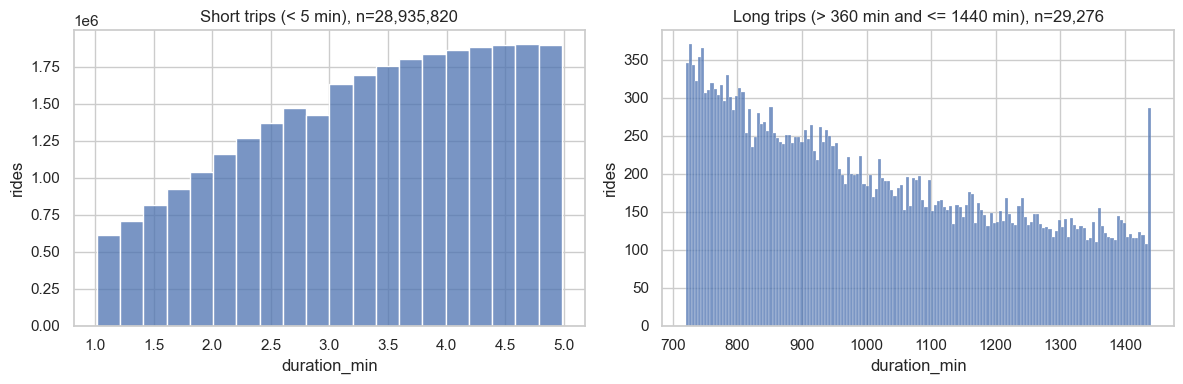

: 

In [ ]:
long_trips_sample_60 = duration.filter((pl.col("duration_min") > 60) & (pl.col("duration_min") <= 720)).select(pl.col("duration_min")).collect().to_pandas()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.histplot(long_trips_sample_60["duration_min"], bins=150)
plt.title(f"Long trips (> 60 min), n={len(long_trips_sample_60):,}")
plt.xlabel("duration_min")
plt.ylabel("rides")

long_trips_sample_360 = duration.filter((pl.col("duration_min") > 720) & (pl.col("duration_min") <= 1440)).select(pl.col("duration_min")).collect().to_pandas()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 2)
sns.histplot(long_trips_sample_360["duration_min"], bins=150)
plt.title(f"Long trips (> 360 min and <= 1440 min), n={len(long_trips_sample_360):,}")
plt.xlabel("duration_min")
plt.ylabel("rides")


short_trips_sample = duration.filter(pl.col("duration_min") < 5).select(pl.col("duration_min")).collect().to_pandas()

plt.subplot(1, 2, 1)
sns.histplot(short_trips_sample["duration_min"], bins=20)
plt.title(f"Short trips (< 5 min), n={len(short_trips_sample):,}")
plt.xlabel("duration_min")
plt.ylabel("rides")

plt.tight_layout()